In [15]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.81 s
Wall time: 2.58 s


In [3]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

ref_literature = datasets.reference_publications(taxon)

agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

gene2pubmed = gene2lit
gene2pubmed = pd.merge(gene2pubmed, ml, how='left')
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values

# no cutoff year
gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

Main figure and 2003 figure

In [4]:
df_array = []

t = pd.read_csv('../data/gwas_all_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_all_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_all_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_all_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [13]:
pmid_dict = hits_df.groupby('type')['pubmed_id'].apply(set)

In [8]:
prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

In [20]:
def pval_str(pval):
    pval_str = ''
    if pval < 0.05:
        pval_str += '*'
    if pval < 0.01:
        pval_str += '*'
    if pval < 0.001:
        pval_str += '*'
    return pval_str

# Regular figure

0.0033147585487924252
2.3491471821400954e-06
1.4195598313245077e-61
5.4746861672519e-238
1.8191748189947602e-37
1.7286816809026082e-55
1.1777794574064508e-11
4.2580035890575485e-19


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


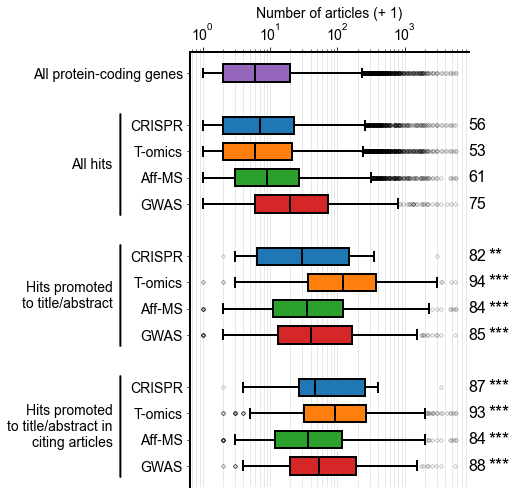

In [23]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    stat, p = scipy.stats.mannwhitneyu(data[0], data[1])
    pos = positions[1]
    ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
    print(p)
    
    stat, p = scipy.stats.mannwhitneyu(data[0], data[2])
    pos = positions[2]
    ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
    print(p)
    
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    percentiles = ecdf([np.median(dat) for dat in data])
    
    for pos, percentile in zip(positions, percentiles):
        ax.text(s=str(int(percentile*100)), 
                x=max_val*1.5, 
                y=pos, 
                ha='left', va='center', fontsize=16)
    #for pos in positions[1:]:
    #    ax.text(s='***', x=max_val*3, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

plt.savefig('../img/filter_figure.png', dpi=300, bbox_inches='tight')
plt.savefig('../img/filter_figure.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure.pdf', date=True)
export.raster_image('general', p='figures/filter_figure.png', date=True, dpi=600)

# Before 2003

0.08555388411564865
0.0007841227792547982
3.2077168962383254e-45
3.8587191903372124e-144
3.724406021403275e-14
4.111630725901587e-20
2.585714114707643e-06
4.0753821523652326e-08


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


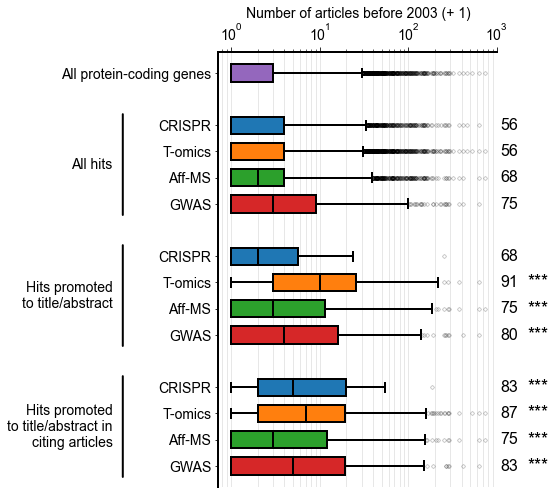

In [25]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed[gene2pubmed['year'] <= 2002]
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type)) & 
                    (gene2pubmed['year'] <= 2002)]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    stat, p = scipy.stats.mannwhitneyu(data[0], data[1])
    pos = positions[1]
    ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
    print(p)
    
    stat, p = scipy.stats.mannwhitneyu(data[0], data[2])
    pos = positions[2]
    ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
    print(p)
    
    #max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    percentiles = ecdf([np.median(dat) for dat in data])
    
    for pos, percentile in zip(positions, percentiles):
        ax.text(s=str(int(percentile*100)), 
                x=max_val*1.5, 
                y=pos, 
                ha='left', va='center', fontsize=16)
    #for pos in positions[1:]:
    #    ax.text(s='***', x=max_val*3, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles before 2003 (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

plt.savefig('../img/filter_figure_up_to_2003_.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure_up_to_2003_.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure_up_to_2003_.pdf', date=True)
export.raster_image('general', p='figures/filter_figure_up_to_2003_.png', date=True, dpi=600)

# Alternative p value thresholds

In [32]:
df_array = []

t = pd.read_csv('../data/gwas_all_hits_1e-10.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_all_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_all_hits_0.0001.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_all_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

1.5505411251975383e-34
1.166318431452727e-123
1.6162770162512436e-09
2.157717057932911e-10


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


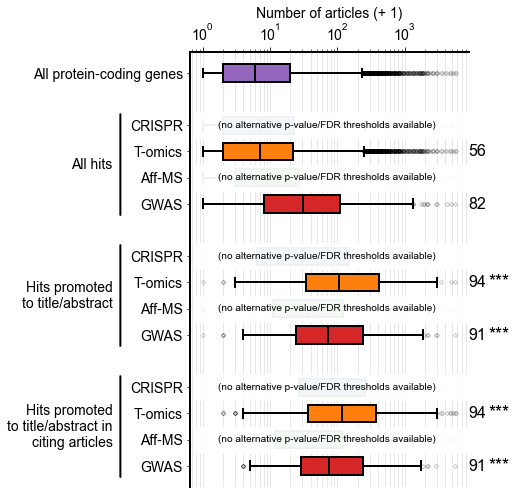

In [35]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = dict()
    hits_dict['hits'] = set(hits_df_slice[hits_df_slice['hit']]['gene_ncbi'])
    hits_dict['mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned']]['gene_ncbi'])
    hits_dict['citations_mentioned_hits'] = set(hits_df_slice[hits_df_slice['mentioned_citations']]['gene_ncbi'])
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    if (hit_type != 'crispr') & (hit_type != 'aff_ms'):
        stat, p = scipy.stats.mannwhitneyu(data[0], data[1])
        pos = positions[1]
        ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
        print(p)
        
        stat, p = scipy.stats.mannwhitneyu(data[0], data[2])
        pos = positions[2]
        ax.text(s=pval_str(p), x=max_val*3, y=pos, ha='left', va='center', fontsize=18)
        print(p)
        
        percentiles = ecdf([np.median(dat) for dat in data])
    
        for pos, percentile in zip(positions, percentiles):
            ax.text(s=str(int(percentile*100)), 
                    x=max_val*1.5, 
                    y=pos, 
                    ha='left', va='center', fontsize=16)
        
    else:
        for pos in positions:
                ax.text(s='(no alternative p-value/FDR thresholds available)', 
                        x=70, 
                        y=pos, ha='center', va='center', fontsize=10, zorder=200)
    
    #for pos in positions[1:]:
    #    ax.text(s='***', x=max_val*3, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

ax.set_xlim(ax.get_xlim())
ax.fill_between(y1=[-0.7,-0.7], y2=[-0.9,-0.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-1.7,-1.7], y2=[-1.9,-1.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-2.7,-2.7], y2=[-2.9,-2.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)

ax.fill_between(y1=[-1.1,-1.1], y2=[-1.3,-1.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-2.1,-2.1], y2=[-2.3,-2.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-3.1,-3.1], y2=[-3.3,-3.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)

plt.savefig('../img/filter_figure_alt_p.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure_alt_p.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure_alt_p.pdf', date=True)
export.raster_image('general', p='figures/filter_figure_alt_p.png', date=True, dpi=600)

In [29]:
hits_df

,gene_ncbi,set,type
0,1,genome,gwas
1,2,genome,gwas
2,100129239,genome,gwas
3,131076,genome,gwas
4,9,genome,gwas
...,...,...,...
128960,23265,citations_mentioned_hits,crispr
128961,79977,citations_mentioned_hits,crispr
128962,5867,citations_mentioned_hits,crispr
128963,7023,citations_mentioned_hits,crispr
